In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as pl


# Import the random forest package
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn import svm

__author__ = 'gulinvladimir'

def main():
    #args = parse_args()

    train_data = np.loadtxt("spam.train.txt")
    test_data  = np.loadtxt("spam.test.txt")

    total_data = np.concatenate(([train_data, test_data]), axis=0)

    # Visualizations of data
    #visualize_classes(total_data[0::, 1::], total_data[0::, 0])
    #visualize_data(total_data[0::, 1::], len(train_data[:,0]), len(test_data[:,0]))

    number_of_features = len(train_data[0, :])

    use_features_in_tree = (int)(0.9 * number_of_features)

    # Create the random forest classifier
    print("Build random forest classifier...")
    forest = RandomForestClassifier(n_estimators = 5, max_features=use_features_in_tree)
    forest = forest.fit(train_data[0::, 1::], train_data[0::, 0])
    prediction_randomforest = forest.predict(test_data[0::, 1::])

    #Create adaboost classifier
    print("Build adaboost classifier...")
    adaboost_classifier = AdaBoostClassifier(n_estimators= 5)
    adaboost_classifier.fit(train_data[0::, 1::], train_data[0::, 0])
    prediction_adaboost = adaboost_classifier.predict(test_data[0::, 1::])

    #Create gbm classifier
    print("Build gbm classifier...")
    gbm_classifier = GradientBoostingClassifier(n_estimators= 5)
    gbm_classifier.fit(train_data[0::, 1::], train_data[0::, 0])
    prediction_gbm = gbm_classifier.predict(test_data[0::, 1::])

    #Create svm classifier
    print("Build svm classifier...")
    svm_classifier = svm.SVC()
    svm_classifier.fit(train_data[0::, 1::], train_data[0::, 0])
    prediction_svm = svm_classifier.predict(test_data[0::, 1::])

    print(classification_report(test_data[0::, 0], prediction_randomforest, 'Random Forest'))
    print(classification_report(test_data[0::, 0], prediction_adaboost, 'AdaBoost'))
    print(classification_report(test_data[0::, 0], prediction_gbm, 'Gradient Boosting Machine'))
    print(classification_report(test_data[0::, 0], prediction_svm, 'SVM'))


def visualize_classes(total_data, response):
    ''' Visualization of total spam data
    :param total_data: Train and test data
    :param response: answers
    :return:
    '''
    pca = PCA(n_components=2)
    projection = pca.fit_transform(total_data)

    not_spam_class = np.where(response == 0)
    spam_class = np.where(response == 1)

    fig = pl.figure(figsize=(8, 8))
    pl.rcParams['legend.fontsize'] = 10

    pl.plot(projection[not_spam_class, 0], projection[not_spam_class, 1],
            'o', markersize=7, color='blue', alpha=0.5, label='Not spam')

    pl.plot(projection[spam_class, 0], projection[spam_class, 1],
            'o', markersize=7, color='red', alpha=0.5, label='Spam')

    pl.title('Spam data')
    pl.show()


def visualize_data(total_data, train_size, test_size):
    ''' Visualization of total spam data
    :param total_data: Train and test data
    :param train_size: Size of train set
    :param test_size: Size of test set
    :return:
    '''
    pca = PCA(n_components=2)
    projection = pca.fit_transform(total_data)

    fig = pl.figure(figsize=(8, 8))

    pl.rcParams['legend.fontsize'] = 10
    pl.plot(projection[0:train_size, 0], projection[0:train_size, 1],
            'o', markersize=7, color='blue', alpha=0.5, label='Train')
    pl.plot(projection[train_size:train_size+test_size, 0], projection[train_size:train_size+test_size, 1],
            'o', markersize=7, color='red', alpha=0.5, label='Test')
    pl.title('Spam data')
    pl.show()


def classification_report(y_true, y_pred, alg_name=None):
    ''' Computes clasification metrics

    :param y_true - original class label
    :param y_pred - predicted class label
    :return presicion, recall for each class; micro_f1 measure, macro_f1 measure
    '''

    if (alg_name != None):
        print(alg_name + " :")

    last_line_heading = 'avg / total'
    final_line_heading = 'final score'

    labels = unique_labels(y_true, y_pred)

    width = len(last_line_heading)
    target_names = ['{0}'.format(l) for l in labels]

    headers = ["precision", "recall", "f1-score", "support"]
    fmt = '%% %ds' % width  # first column: class name
    fmt += '  '
    fmt += ' '.join(['% 9s' for _ in headers])
    fmt += '\n'

    headers = [""] + headers
    report = fmt % tuple(headers)
    report += '\n'

    p, r, f1, s = precision_recall_fscore_support(y_true, y_pred,
                                                  labels=labels,
                                                  average=None)

    f1_macro = 0
    precision_macro = 0
    recall_macro = 0

    for i, label in enumerate(labels):
        values = [target_names[i]]
        f1_macro += f1[i]
        precision_macro += p[i]
        recall_macro += r[i]
        for v in (p[i], r[i], f1[i]):
            values += ["{0:0.5f}".format(v)]
        values += ["{0}".format(s[i])]
        report += fmt % tuple(values)

    report += '\n'

    # compute averages
    values = [last_line_heading]
    for v in (np.average(p, weights=s),
              np.average(r, weights=s),
              np.average(f1, weights=s)):
        values += ["{0:0.5f}".format(v)]
    values += ['{0}'.format(np.sum(s))]
    report += fmt % tuple(values)

    values = [final_line_heading]
    for v in (precision_macro, recall_macro, f1_macro):
        values += ["{0:0.5f}".format(v / labels.size)]
    values += ['{0}'.format(np.sum(s))]
    report += fmt % tuple(values)

    return report

def parse_args():
    parser = argparse.ArgumentParser(description='Random Forest Tutorial')
    parser.add_argument("-tr", "--train", action="store", type=str, help="Train file name")
    parser.add_argument("-te", "--test", action="store", type=str, help="Test file name")
    parser.add_argument("-t", "--trees", action="store", type=int, help="Number of trees in random forest", default=5)
    parser.add_argument("-fp", "--features_percent", action="store", type=float, help="Percent of features in each tree", default=0.9)
    return parser.parse_args()

In [2]:
main()

Build random forest classifier...
Build adaboost classifier...
Build gbm classifier...
Build svm classifier...
Random Forest :
             precision    recall  f1-score   support

        0.0    0.58208   0.76390   0.66071      2033
        1.0    0.93503   0.86102   0.89650      8023

avg / total    0.86368   0.84139   0.84883     10056
final score    0.75856   0.81246   0.77861     10056

AdaBoost :
             precision    recall  f1-score   support

        0.0    0.92398   0.42450   0.58173      2033
        1.0    0.87174   0.99115   0.92762      8023

avg / total    0.88230   0.87659   0.85769     10056
final score    0.89786   0.70782   0.75467     10056

Gradient Boosting Machine :
             precision    recall  f1-score   support

        0.0    0.67766   0.84899   0.75371      2033
        1.0    0.95912   0.89767   0.92738      8023

avg / total    0.90221   0.88783   0.89227     10056
final score    0.81839   0.87333   0.84054     10056

SVM :
             precision  

Подобрать параметры трёх алгоритмических композиций, чтобы они превосходили по качеству SVM, логистическую регрессию и двуслойный персептрон. Построить графики качества классификации в зависимости от числа базовых моделей.

In [3]:
train_data = np.loadtxt("spam.train.txt")
test_data  = np.loadtxt("spam.test.txt")

X_train, y_train = train_data[0::, 1::], train_data[0::, 0]
X_test, y_test = test_data[0::, 1::], test_data[0::, 0]

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression

###### SVM

In [5]:
svm_classifier = svm.SVC()
svm_classifier.fit(X_train, y_train)
y_pred = svm_classifier.predict(X_test)
f1_score(y_test, y_pred)

0.9585241566148487

In [6]:
print(classification_report(y_test, y_pred, 'SVM'))

SVM :
             precision    recall  f1-score   support

        0.0    0.76980   0.97541   0.86049      2033
        1.0    0.99332   0.92609   0.95852      8023

avg / total    0.94813   0.93606   0.93870     10056
final score    0.88156   0.95075   0.90951     10056



###### Логистическая регрессия

In [7]:
logreg_classifier = LogisticRegression(max_iter=1000)
logreg_classifier.fit(X_train, y_train)
y_pred = logreg_classifier.predict(X_test)
f1_score(y_test, y_pred)

0.9354669464847849

In [8]:
print(classification_report(y_test, y_pred, 'Logistic regression'))

Logistic regression :
             precision    recall  f1-score   support

        0.0    0.68527   0.95425   0.79770      2033
        1.0    0.98713   0.88894   0.93547      8023

avg / total    0.92610   0.90215   0.90761     10056
final score    0.83620   0.92160   0.86658     10056



###### Двуслойный перцептрон

In [9]:
import torch 
from torch.nn import MSELoss, Linear, Sigmoid

class Feedforward(torch.nn.Module):
        def __init__(self, input_size, hidden_size = 100):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.hidden_size  = hidden_size
            self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.fc2 = torch.nn.Linear(self.hidden_size, 1)
            self.sigmoid = torch.nn.Sigmoid()
        def forward(self, x):
            hidden = self.fc1(x)
            output = self.sigmoid(hidden)
            output = self.fc2(output)
            return output
def train(model, X_train, y_train, epochs=400, learning_rate=0.01, criterion=MSELoss(), optim=torch.optim.Adam):
            optimizer = optim(model.parameters(), lr=learning_rate)
            for epoch in range(epochs):
                optimizer.zero_grad()
                # Forward pass
                y_pred = model(X_train)
                # Compute Loss
                loss = criterion(y_pred, y_train)
                print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
                # Backward pass
                loss.backward()
                optimizer.step()


In [10]:
twolayer_perceptron = Feedforward(input_size = X_train.shape[1])
train(twolayer_perceptron, torch.from_numpy(X_train).float(), torch.from_numpy(y_train[:,np.newaxis]).float())
y_pred = twolayer_perceptron(torch.from_numpy(X_test).float())
f1_score(y_test[:,np.newaxis], (y_pred.detach().numpy() > 0.5).astype(int))

Epoch 0: train loss: 0.2778816521167755
Epoch 1: train loss: 1.1422619819641113
Epoch 2: train loss: 0.3186672627925873
Epoch 3: train loss: 0.3964013457298279
Epoch 4: train loss: 0.6667876243591309
Epoch 5: train loss: 0.5303003787994385
Epoch 6: train loss: 0.2993091642856598
Epoch 7: train loss: 0.2293444126844406
Epoch 8: train loss: 0.31423911452293396
Epoch 9: train loss: 0.39798611402511597
Epoch 10: train loss: 0.38474830985069275
Epoch 11: train loss: 0.3042297065258026
Epoch 12: train loss: 0.23262257874011993
Epoch 13: train loss: 0.21532107889652252
Epoch 14: train loss: 0.2440900206565857
Epoch 15: train loss: 0.2798450291156769
Epoch 16: train loss: 0.2901168167591095
Epoch 17: train loss: 0.26942405104637146
Epoch 18: train loss: 0.23452496528625488
Epoch 19: train loss: 0.207485169172287
Epoch 20: train loss: 0.2007443755865097
Epoch 21: train loss: 0.21140426397323608
Epoch 22: train loss: 0.22595512866973877
Epoch 23: train loss: 0.23112919926643372
Epoch 24: train l

Epoch 215: train loss: 0.06511510908603668
Epoch 216: train loss: 0.06506792455911636
Epoch 217: train loss: 0.0650210827589035
Epoch 218: train loss: 0.0649745762348175
Epoch 219: train loss: 0.06492842733860016
Epoch 220: train loss: 0.06488261371850967
Epoch 221: train loss: 0.06483714282512665
Epoch 222: train loss: 0.06479199230670929
Epoch 223: train loss: 0.06474717706441879
Epoch 224: train loss: 0.06470269709825516
Epoch 225: train loss: 0.06465854495763779
Epoch 226: train loss: 0.06461472064256668
Epoch 227: train loss: 0.06457120925188065
Epoch 228: train loss: 0.06452803313732147
Epoch 229: train loss: 0.06448516994714737
Epoch 230: train loss: 0.06444261223077774
Epoch 231: train loss: 0.06440038233995438
Epoch 232: train loss: 0.06435845792293549
Epoch 233: train loss: 0.06431684643030167
Epoch 234: train loss: 0.06427554041147232
Epoch 235: train loss: 0.06423453986644745
Epoch 236: train loss: 0.06419383734464645
Epoch 237: train loss: 0.06415344029664993
Epoch 238: tr

0.9372182661527405

In [11]:
print(classification_report(y_test[:,np.newaxis], (y_pred.detach().numpy() > 0.5).astype(int), 'Twolayer perceptron'))

Twolayer perceptron :
             precision    recall  f1-score   support

        0.0    0.69336   0.94540   0.80000      2033
        1.0    0.98476   0.89405   0.93722      8023

avg / total    0.92585   0.90444   0.90948     10056
final score    0.83906   0.91973   0.86861     10056



In [12]:
from tqdm import tqdm
n_estimators = list(range(100, 1000, 50)) 

def tune_n_estimators(clf, X_train, y_train, clf_name):
    best_n_estimators = n_estimators[0]
    best_score = 0
    scores = []

    for cur_n_estimators in tqdm(n_estimators):
        clf = clf.set_params(**{'n_estimators': cur_n_estimators})
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = f1_score(y_test, y_pred)
        scores.append(score)
        if score > best_score:
            best_n_estimators = cur_n_estimators
            best_score = score

    plt.plot(n_estimators, scores)            
    plt.title('n_estimators tuning for ' + clf_name)
    plt.xlabel('n_estimators')
    plt.ylabel('f1-score')
    
    return scores, best_score, best_n_estimators


100%|██████████| 18/18 [03:33<00:00, 11.85s/it]

f1-score=0.9664250286150324, n_estimators=750


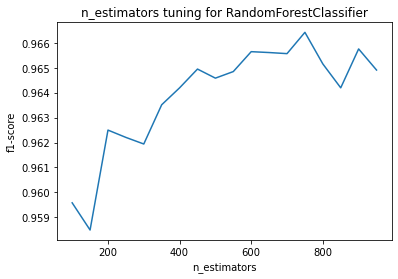

In [13]:
rforest = RandomForestClassifier()
scores, best_score, best_n_estimators = tune_n_estimators(rforest, X_train, y_train, clf_name = 'RandomForestClassifier')
print(f'f1-score={best_score}, n_estimators={best_n_estimators}')

100%|██████████| 18/18 [05:38<00:00, 18.82s/it]

f1-score=0.9599457727384767, n_estimators=150


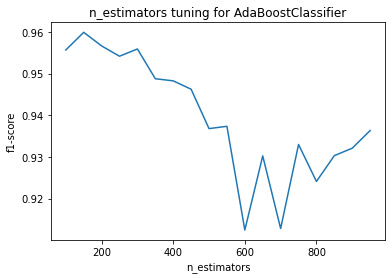

In [14]:
ab = AdaBoostClassifier()
scores, best_score, best_n_estimators = tune_n_estimators(ab, X_train, y_train, clf_name = 'AdaBoostClassifier')
print(f'f1-score={best_score}, n_estimators={best_n_estimators}')

100%|██████████| 18/18 [12:39<00:00, 42.19s/it]

f1-score=0.9752909690670319, n_estimators=250


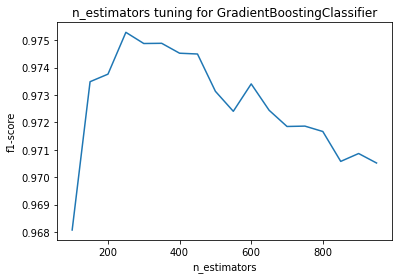

In [15]:
gbm = GradientBoostingClassifier()
scores, best_score, best_n_estimators = tune_n_estimators(gbm, X_train, y_train, clf_name = 'GradientBoostingClassifier')
print(f'f1-score={best_score}, n_estimators={best_n_estimators}')